# Preparation

This [dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) contains labelled sentences scored either with a 1 for positive sentences and 0 for negatives. Sentences com from three different websites:

- imdb.com
- amazon.com
- yelp.com

Each of them combine ~500 positives and ~500 negatives sentences.
> "We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected."

This dataset was created for the paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015. They are also the creators of this awesome dataset.


In [0]:
import pandas as pd

root_path = '/content/drive/notebooks/datasets/'
dataset_path = 'sentiment-labelled-sentences/'
directory = root_path+dataset_path

amazon_path = 'amazon_cells_labelled.txt'
imdb_path = 'imdb_labelled.txt'
yelp_path= 'yelp_labelled.txt'

columns=['sentence', 'score']
amazon = pd.read_csv(directory+amazon_path, sep='\t', names=columns, header=None)
imdb = pd.read_csv(directory+imdb_path, sep='\t', names=columns, header=None)
yelp = pd.read_csv(directory+yelp_path, sep='\t', names=columns, header=None)

Let's merge the three datasets into one.

In [0]:
df = pd.concat([amazon, imdb, yelp])
df.score.value_counts()
df.head(5)

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## Sentences cleanup

We can now pre-process our sentences.

- Lower case
- Clean out ponctuation
- Remove common terms (stop words, we grabbed [this list](https://github.com/Alir3z4/stop-words/blob/0e438af98a88812ccc245cf31f93644709e70370/english.txt))
- Space out exclamation points and question marks from their attached word (ex: hello? to hello ?)

In [0]:
def prepare_text_column(df, punctuations=None, stop_words=None, replace_dict=None, copy=False):
  def space_out_marks(clean_df):
    # Changes 'is that all right?'
    # In      'is that all right ?'
    marks = ['?', '!', '\.', ')', '(']
    for m in marks:
      df.replace(to_replace=r'(\%s)+'%m, value=' {0}'.format(m), 
                         regex=True, inplace=True)
  
  def lower_case(df):
    return df.str.lower()
  
  def remove_words(df, words_to_delete):
    for w in words_to_delete:
      df.replace(to_replace=r'\b(%s)\b'%w, value="", 
                         regex=True, inplace=True)
    return df
    
  def remove_punctuation(df, punctuation):
    for p in punctuations:
      df.replace(to_replace=r'(%s)'%p, value=" ", 
                         regex=True, inplace=True)    
    return df
  
  def replace_from_dict(df, replace_dict):
    for l, replacement in replace_dict:
      for w in l:
        df.replace(to_replace=r'\b(%s)\b'%w, value="not", 
                           regex=True, inplace=True)
    return df
      
  clean_df = pd.Series()
  if(copy):
    clean_df = df.copy()
  else:
    clean_df = df
  
  clean_df = lower_case(clean_df)
  space_out_marks(clean_df)
  
  if(punctuations is not None):
    remove_punctuation(clean_df, punctuations)

  if(replace_dict is not None):
    replace_from_dict(clean_df, replace_dict)
  
  if(stop_words is not None):
    remove_words(clean_df, words_to_delete=stop_words)
  
  clean_df.replace('\s+', ' ', regex=True, inplace=True)
  
  return clean_df

Stopwords are words that doesn't give much information from [here](https://github.com/Alir3z4/stop-words/blob/0e438af98a88812ccc245cf31f93644709e70370/english.txt).

To keep in mind: 'not', 'don't' 'didn't' ect... are considered as stopwords. But for sentiment analysis we might want to keep the information of 'not'. So we need to expands the contractions in english language ([list on SO](https://stackoverflow.com/questions/43018030/replace-appostrophe-short-words-in-python)).

In [0]:
import numpy as np
import random

def get_stop_words(filepath):
  english_stop = pd.read_csv(filepath, sep='\t', names=columns, header=None)
  return np.array(english_stop.values[:,0])

english_stop = get_stop_words(root_path+'english-stop-words.txt')

replace_to_not = ["don t", "didn t", "won t", "cannot", 
                 "can t", "doesn t", "hasn t", "haven t", "hadn t", "isn t", 
                  "shouldn t", "mustn t", "wasn t"
                "wouldn t", "aren t", "hadn t", "weren t"]

english_stop = [w for w in english_stop if w not in replace_to_not]

english_stop = np.array(english_stop)
english_stop = np.delete(english_stop, english_stop.tolist().index('not'))

print_max_sw = 15
s = '%s, '
s = [s for se in range(print_max_sw)]
print('Examples of stop words: '+''.join(s) % tuple([random.choice(english_stop) for i in range(print_max_sw)]))

Examples of stop words: its, ought, there's, other, themselves, some, on, for, who, i'm, themselves, he, ourselves, himself, over, 


We want to keep punctuations that are used to make smiley like `:(` and `:)`? Not used much in this dataset.

In [0]:
punctuation= [',', '\.', '\'', '\"', '-', '_', '!', '\(', '\)', '$', ';']

replace_dict = [(replace_to_not, ' not'), #change doesn't in does not
                (["s"], ' is'),
                (["ve'"], '  have'),
               (["ll"], 'will'),
               (["m"], "am"),
               (["d"], "had")]

# We just lower case and remove punctuation
df['sentence'] = prepare_text_column(df['sentence'],
                                     punctuations=punctuation,)
cleaned_df = df.copy()
cleaned_df['sentence'] = prepare_text_column(df['sentence'], 
                         stop_words=english_stop,
                         punctuations=punctuation,
                         replace_dict=replace_dict)

In [0]:
cleaned_df.head(5)

,sentence,score
0,way plug us unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversations lasting 45 minutes ...,0
4,mic great,1


# Vocabulary size and padding limit

How many words are used less than X times. Words need to appear several times to be leaned by the model.

Let's see the difference between the top-n words before and after processing punctuation, stop words and doing some replacements. We'll train the model on the two sets to see the impact.

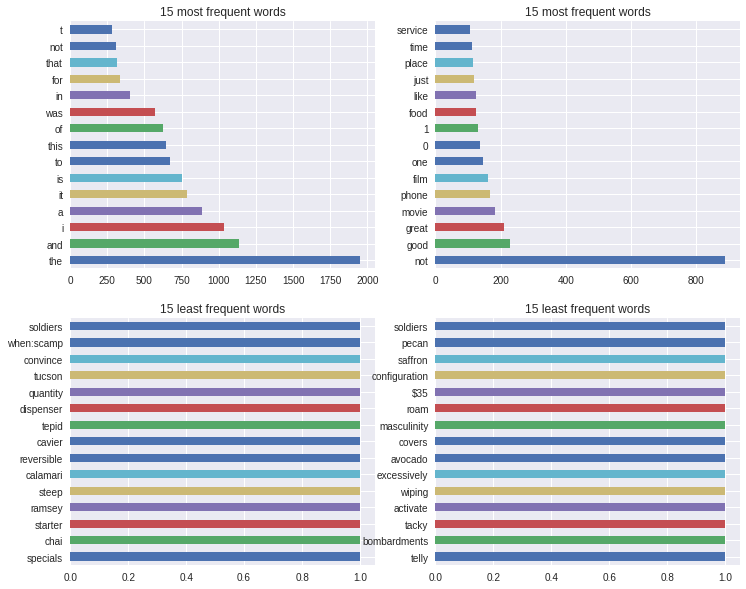

In [0]:
import matplotlib.pyplot as plt

def plot_extremum_word_usage(df, n, most=True):
  min_or_max = 'most'         if most else 'least'
  to_display = slice(None, n) if most else slice(-n,None)
  
  top_n = pd.Series(' '.join(df).split()).value_counts()[to_display]
  top_n.plot.barh(title='{0} {1} frequent words'.format(n, min_or_max), figsize=(12,10));
  
def compare_least_most_word_usages(left, right, n=15):
  plt.figure(figsize=(15,15))
  plt.subplot(221)
  plot_extremum_word_usage(left, n)
  plt.subplot(222)
  plot_extremum_word_usage(right, n)
  plt.subplot(223)
  plot_extremum_word_usage(left, n, most=False)
  plt.subplot(224)
  plot_extremum_word_usage(right, n, most=False)


compare_least_most_word_usages(left=df['sentence'], right=cleaned_df['sentence'])

We will focus on the 466 most frequent words (used more than 6 times in the whole corpus).


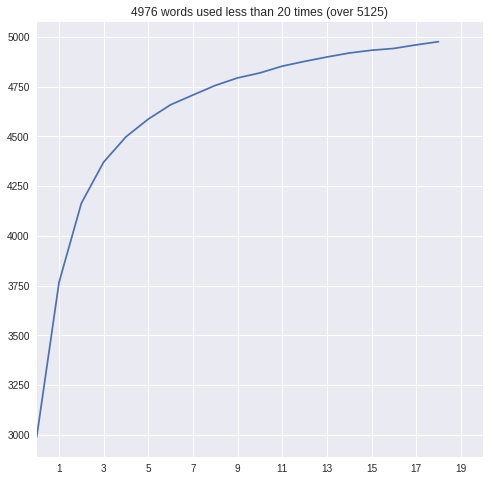

In [0]:
def get_cumul_word_usage(column, n_max=20, plot=True):
  to_display = slice(None, n_max) if n_max is not None else slice(None, None)
  used_per_word = pd.Series(' '.join(column).split()).value_counts()[::-1]
  
  to_plot = []
  for current_max in range(1,n_max):
    less_used = len(used_per_word[used_per_word <= current_max])
    to_plot.append(less_used)
  
  total_words_count = len(used_per_word)
  title='{0} words used less than {1} times (over {2})'.format(to_plot[-1], n_max, total_words_count)
  pd.Series(to_plot).plot(title=title, figsize=(8,8), 
                                xlim =(0,n_max), xticks=range(1,n_max,int(n_max/20)+1));
  return to_plot, total_words_count


word_usage_cumul, word_count = get_cumul_word_usage(cleaned_df['sentence'], 20)

minimum_usage = 6
vocabulary_size = word_count - word_usage_cumul[minimum_usage]
print('We will focus on the {0} most frequent words (used more than {1} times in the whole corpus).'.format(vocabulary_size, minimum_usage))

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=vocabulary_size, split=' ')
tokenizer.fit_on_texts(cleaned_df['sentence'].values)

X = tokenizer.texts_to_sequences(cleaned_df['sentence'].values)

Let's look at the sentence length and set padding parameters.

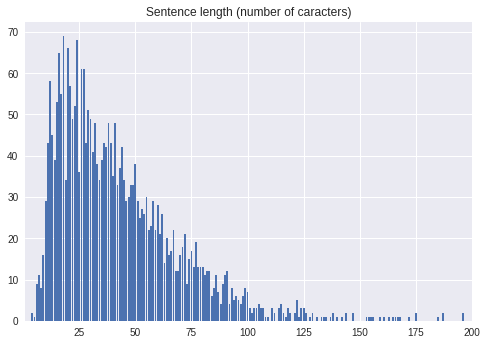

In [0]:
raw_cleaned_lengths = cleaned_df.sentence.str.len()
cleaned_lengths = raw_cleaned_lengths.value_counts().reset_index(level=0)
cleaned_lengths.rename(columns={'index': 'count', 'sentence': 'sentence_length'}, inplace=True)

plt.xlim(1,200)
plt.bar(cleaned_lengths['count'], cleaned_lengths['sentence_length']);
plt.title('Sentence length (number of caracters)');

Sentences and tokens' length follow a (somewhat) Gaussian distribution.
So if we consider that we can keep ~99% of the dataset without loss by limiting the number of tokens to `mean(u) + 3*std(u)`.

99% of the sentences in our dataset contain 42 tokens (max=485)


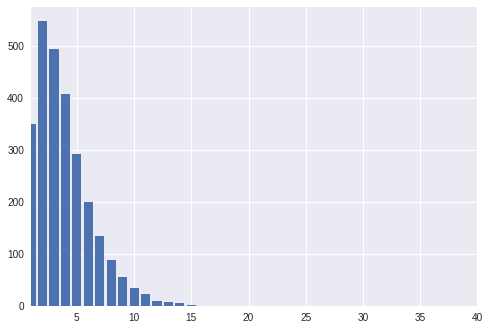

In [0]:
number_of_tokens = np.array([len(x) for x in X])

max_token_per_phrase = int(number_of_tokens.mean() + 3 * number_of_tokens.std())
print('99% of the sentences in our dataset contain {0} tokens (max={1})'.format(max_token_per_phrase,max(number_of_tokens)))

uniques = np.bincount(number_of_tokens);
plt.xlim(1,40);
plt.bar(range(0,len(uniques)),uniques );

In [0]:
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=max_token_per_phrase)
y = pd.get_dummies(df['score']).values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['score'].values, 
                                                    test_size=0.2, 
                                                    random_state=4422)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                  stratify=y_train, 
                                                  test_size=0.2, 
                                                  random_state=4422)

In [0]:
print('[Sizes] train: {0}, validation: {1}, test: {2}'.format(len(X_train), len(X_val), len(X_test)))

[Sizes] train: 1758, validation: 440, test: 550


# Embedding and modeling

In [0]:
from keras.callbacks import History

class PlotHistory(History):
  def __init__(self, plot_validation=True, monitor=['acc'], figsize=(15,10)):
    self.plot_validation = plot_validation
    self.metrics = monitor
    plt.figure(figsize=figsize)
    
  def on_train_end(self, logs=None):
    for index, metric in enumerate(self.metrics):
      ax = plt.subplot(2, 2, index + 1)
      ax.plot(self.history[metric], label=metric)
      if(self.plot_validation):
        val = 'val_{0}'.format(metric)
        ax.plot(self.history[val], label=val)

      ax.legend(framealpha=0.8, fancybox=True)

      min_rounded_value = round(min(self.history[metric]), 1)
      max_sup_value =  max(self.history[metric])+0.05
      plt.yticks(np.arange(min_rounded_value, max_sup_value, step=0.05))

      max_epoch = len(self.history[metric])
      step = int(max_epoch/15) if (max_epoch > 30) else 2
      plt.xticks(np.arange(0, max_epoch, step=step))
      ax.set(xlabel='Epoch')

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, Flatten
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def make_model(p):
  model = Sequential()
  model.add(Embedding(input_dim=p['vocabulary_size'], 
                      output_dim=p['dense_vector_dim'],
                      input_length=p['max_len_sequence'],
                      mask_zero = True))
  
  if p['lstm_stack_depth'] > 0:
    model.add(SpatialDropout1D(p['embedding_spatial_dropout']))
  
  for i in range(p['lstm_stack_depth']):
    return_sequence = True if (i+1) != p['lstm_stack_depth'] else False
    
    model.add(Bidirectional(LSTM(p['lstm_hidden_neurons'], 
                   dropout=p['lstm_dropout'], 
                   recurrent_dropout=p['lstm_rec_dropout'], 
                   return_sequences=return_sequence)))

  for i in range(p['dense_layer_count']):
    model.add(Dense(p['dense_layer_size'], activation='relu'))
    model.add(Dropout(p['dense_layer_dropout']))
  
  model.add(Dense(p['window_width']));
  model.add(Dense(2,activation='softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  return model

- 1 We turn each number representing a word into a dense vector
- 2 We drop randomly some connections
- 3 We stack an LSTM layer with a large dropout to prevent overfitting
- 4 We finaly cover the top by some dense layers 

In [0]:
params_lstm_sentiment = {
    'embedding_spatial_dropout': 0.3, 
    'lstm_dropout': 0.45, 
    'lstm_rec_dropout': 0.35, 
    'dense_layer_dropout': 0.25, 
    'window_width': 5, 
    'lstm_hidden_neurons': 50, 
    'dense_vector_dim': 200, 
    'dense_layer_size': 70, 
    'dense_layer_count': 1, 
    'vocabulary_size': vocabulary_size,
    'lstm_stack_depth': 2,
    'max_len_sequence': max_token_per_phrase,
}

# Parameters found in the next section
hyper_parameters_best = {
    'embedding_spatial_dropout': 0.2, 
    'lstm_dropout': 0.4, 
    'lstm_rec_dropout': 0.25, 
    'dense_layer_dropout': 0.2, 
    'window_width': 11, 
    'lstm_hidden_neurons': 80, 
    'dense_vector_dim': 175, 
    'dense_layer_size': 70, 
    'dense_layer_count': 2, 
    'lstm_stack_depth': 2, 
    'vocabulary_size': vocabulary_size, 
    'max_len_sequence': max_token_per_phrase
}

model = make_model(hyper_parameters_best)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 42, 175)           81550     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 42, 175)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 42, 160)           163840    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 160)               154240    
_________________________________________________________________
dense_9 (Dense)              (None, 70)                11270     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 70)                4970      
__________

Train on 1758 samples, validate on 440 samples
Epoch 1/25
1758/1758 [==============================] - 12s 7ms/step - loss: 0.6910 - acc: 0.5495 - val_loss: 0.6823 - val_acc: 0.7159
Epoch 2/25
1758/1758 [==============================] - 7s 4ms/step - loss: 0.6557 - acc: 0.7133 - val_loss: 0.5864 - val_acc: 0.7432
Epoch 3/25
1758/1758 [==============================] - 8s 4ms/step - loss: 0.5041 - acc: 0.7918 - val_loss: 0.5129 - val_acc: 0.7818
Epoch 4/25
1758/1758 [==============================] - 8s 4ms/step - loss: 0.3761 - acc: 0.8413 - val_loss: 0.4841 - val_acc: 0.8068
Epoch 5/25
1758/1758 [==============================] - 7s 4ms/step - loss: 0.3279 - acc: 0.8578 - val_loss: 0.5145 - val_acc: 0.8023
Epoch 6/25
1758/1758 [==============================] - 7s 4ms/step - loss: 0.3046 - acc: 0.8743 - val_loss: 0.5217 - val_acc: 0.8045
Epoch 7/25
1758/1758 [==============================] - 7s 4ms/step - loss: 0.2834 - acc: 0.8771 - val_loss: 0.5568 - val_acc: 0.8136
Epoch 00007: e

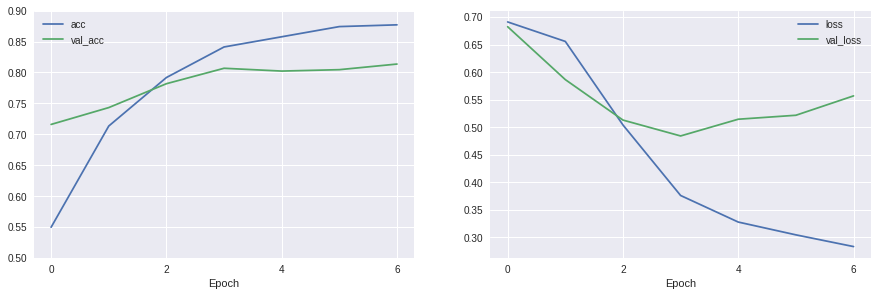

In [0]:
early_stopping_val = EarlyStopping(monitor='val_loss', min_delta=0.001, 
                                   patience=3, verbose=1, mode='auto')

plot_history = PlotHistory(monitor=['acc', 'loss'])
epochs=25
batch_size = 150
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1,
                    callbacks=[early_stopping_val, plot_history],
                    validation_data=(X_val, y_val))                    

In [0]:
test_loss_acc = model.evaluate(X_test, y_test)
print("loss: {0:.5f}, acc: {1:5f}, test size: {2}".format(test_loss_acc[0], 
                                                          test_loss_acc[1],
                                                          len(y_test)))

550/550 [==============================] - 3s 6ms/step
loss: 0.55188, acc: 0.803636, test size: 550


We can visualize errors, we need to spot all the errors in the training set and then rebuild them from the `Tokenizer`. The reconstruction is limited because:
- words used less than X times aren't mapped by the `Tokenizer`
- stop words, punctuation are deleted beforehand

But it's still possible to do a partial search in the original dataset.

In [0]:
test_predictions = model.predict(X_test).argmax(axis=-1)
test_errors_index = y_test.argmax(axis=-1) != test_predictions
test_errors_x = X_test[test_errors_index]
test_errors_y = y_test[test_errors_index]

In [0]:
inv_map = {v: k for k, v in tokenizer.word_index.items()}

errors = []
for index, error in enumerate(test_errors_x):
  errors.append([[inv_map.get(item,item) for item in error if item != 0], test_errors_y[index].argmax(axis=-1)])

label = ['-', '+']
print('Errors:')
for e in errors[:15]:
  if(len(e[0]) == 0): continue
  print("ground truth ({1}) {0} ".format(e[0], label[e[1]]))

Errors:
ground truth (+) ['predictable', 'not', 'bad', 'watch'] 
ground truth (+) ['not', 'think', 'will', 'disappointed'] 
ground truth (+) ['keep', 'good', 'work', 'amazon'] 
ground truth (-) ['made', 'case', 'small'] 
ground truth (+) ['oh', 'thing', 'restaurant'] 
ground truth (-) ['directing', 'best'] 
ground truth (+) ['not'] 
ground truth (+) ['will', 'go', 'back', 'next'] 
ground truth (+) ['used', 'work', 'place', 'really', 'half', 'price'] 
ground truth (+) ['food', 'arrived', 'quickly'] 
ground truth (-) ['just', 'writing', 'come', 'fast'] 
ground truth (+) ['however', 'made', 'film'] 
ground truth (-) ['film', 'glad', 're', 'away', 'far'] 
ground truth (+) ['just', 'good', 'year', 'ago'] 


We can try to test some of our own sentences, it's clearly not perfect but there is something. 


In [0]:
def print_new_predictions(sentences, model, tokenizer, max_pad_len):
  sentences = (pd.Series(sentences))
  to_process = prepare_text_column(sentences, 
                                   stop_words=english_stop,
                                   punctuations=punctuation,
                                   replace_dict=replace_dict,
                                   copy=False)

  other_tests = tokenizer.texts_to_sequences(to_process)
  other_tests = pad_sequences(other_tests, maxlen=max_pad_len)
  inferences = model.predict_classes(other_tests)
  label = ['-', '+']

  predictions = [label[i] for i in inferences]
  for index, pred in enumerate(predictions):
    print('[ {1:2s}]  {0}'.format(sentences[index], pred))

In [0]:
new_sentences = ["this movie was awesome",
              "nice restaurant",
              "terrible headphones !",
              "terribly bad headphones !",
              "we had a good laught at this movie",
              "it's not working",
              "bad",
              'quite bad',
              'quite good',
              "excellent",
              "good",
              "not good",
              "meh",
              "must see !",
              "go away from there !",
              "go there !",
              "This is clearly not one of his best",
              "This is clearly one of his best",
              "i've seen better",
              "refund me",
              "I charged it but it only last 5 minutes..."]

print_new_predictions(new_sentences, model, tokenizer, max_token_per_phrase)

[ + ]  this movie was awesome
[ + ]  nice restaurant
[ - ]  terrible headphones  !
[ - ]  terribly bad headphones  !
[ + ]  we had a good laught at this movie
[ - ]  it's not working
[ - ]  bad
[ - ]  quite bad
[ + ]  quite good
[ + ]  excellent
[ + ]  good
[ - ]  not good
[ - ]  meh
[ + ]  must see  !
[ - ]  go away from there  !
[ + ]  go there  !
[ + ]  This is clearly not one of his best
[ + ]  This is clearly one of his best
[ - ]  i've seen better
[ - ]  refund me
[ - ]  I charged it but it only last 5 minutes...


# Hyperparameters optimisation

Using [`GPYopt`](http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_reference_manual.ipynb) we will optimise those parameters, using a bayesian optimisation method.

    vocabulary_size,
    dense_vector_dim,
    embedding_spatial_dropout,
    lstm_hidden_neurons,
    lstm_dropout,
    lstm_rec_dropout,
    window_width,
    dense_layer_size,
    dense_layer_count,
    dense_layer_dropout
    
    
 
To install the `GPYopt` library you also need to install `GPY` library, both avaiable via pip: 


```
!pip install gpy
!pip install gpyopt
```



In [0]:
import GPy, GPyOpt

def run_model(x):
  parameters = dict(
      embedding_spatial_dropout= float(x[:,0]),
      lstm_dropout=              float(x[:,1]),
      lstm_rec_dropout=          float(x[:,2]),
      dense_layer_dropout=       float(x[:,3]),
      window_width=              int(x[:,4]),
      lstm_hidden_neurons=       int(x[:,5]),
      dense_vector_dim=          int(x[:,6]),
      dense_layer_size=          int(x[:,7]),
      dense_layer_count=         int(x[:,8]),
      lstm_stack_depth=          int(x[:,9]),
      vocabulary_size=           vocabulary_size,
      max_len_sequence=          max_token_per_phrase
  )
  model = make_model(parameters)
  
  batch_size = 128
  max_epochs=25
  patience_early=4
  verbose=0
  early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, 
                            patience=4, verbose=verbose, mode='auto')
  history = model.fit(X_train, y_train, epochs=max_epochs, 
                    batch_size=batch_size, 
                    verbose=verbose,
                    callbacks=[early_stop],
                    validation_data=(X_val, y_val))  
  
  number_epoch = len(history.history['val_loss'])
  best_index = -(patience_early + 1) if (number_epoch < max_epochs and number_epoch > patience_early) else -1
  
  evaluation = [history.history['val_loss'][best_index], 
                history.history['val_acc'][best_index]]
  
  print("[epochs={2}] val_loss: {0:4f} \t val_acc:{1:4f}".format(evaluation[0], 
                                                           evaluation[1], 
                                                           number_epoch))
  print(parameters)
  print()
  return evaluation[0]

# reminder
print('Vocabulary size is {0}'.format(vocabulary_size))

Vocabulary size is 466


In [0]:
dropout_domain = [x/100 for x in range(0, 45, 5)]
bounds = [
    {'name': 'embedding_spatial_dropout', 'type': 'discrete','domain': dropout_domain},
    {'name': 'lstm_dropout',              'type': 'discrete','domain': dropout_domain},
    {'name': 'lstm_rec_dropout',          'type': 'discrete','domain': dropout_domain},
    {'name': 'dense_layer_dropout',       'type': 'discrete','domain': dropout_domain},
    
    {'name': 'window_width',              'type': 'discrete','domain': range(5, 12)},
    {'name': 'lstm_hidden_neurons',       'type': 'discrete','domain': range(20, 150, 10)},
    {'name': 'dense_vector_dim',          'type': 'discrete','domain': range(100, 300, 25)},
    {'name': 'dense_layer_size',          'type': 'discrete','domain': range(50, 100, 10)},
    {'name': 'dense_layer_count',         'type': 'categorical','domain': (1, 2)},
    {'name': 'lstm_stack_depth',          'type': 'categorical','domain': (1, 2)},
]
opt_sentiment = GPyOpt.methods.BayesianOptimization(f=run_model, domain=bounds)

[epochs=7] val_loss: 0.472484 	 val_acc:0.797727
{'embedding_spatial_dropout': 0.25, 'lstm_dropout': 0.25, 'lstm_rec_dropout': 0.4, 'dense_layer_dropout': 0.35, 'window_width': 7, 'lstm_hidden_neurons': 30, 'dense_vector_dim': 100, 'dense_layer_size': 80, 'dense_layer_count': 2, 'lstm_stack_depth': 2, 'vocabulary_size': 466, 'max_len_sequence': 42}

[epochs=15] val_loss: 0.612697 	 val_acc:0.813636
{'embedding_spatial_dropout': 0.4, 'lstm_dropout': 0.4, 'lstm_rec_dropout': 0.05, 'dense_layer_dropout': 0.2, 'window_width': 8, 'lstm_hidden_neurons': 140, 'dense_vector_dim': 175, 'dense_layer_size': 70, 'dense_layer_count': 1, 'lstm_stack_depth': 1, 'vocabulary_size': 466, 'max_len_sequence': 42}

[epochs=11] val_loss: 0.586867 	 val_acc:0.809091
{'embedding_spatial_dropout': 0.1, 'lstm_dropout': 0.25, 'lstm_rec_dropout': 0.15, 'dense_layer_dropout': 0.2, 'window_width': 9, 'lstm_hidden_neurons': 60, 'dense_vector_dim': 175, 'dense_layer_size': 60, 'dense_layer_count': 2, 'lstm_stack_dept

# Testing with different pre-processing of the corpus

Let's see the difference if we don't remove stop words, nor replace any strings.

Train on 1538 samples, validate on 660 samples
Epoch 1/25
 - 16s - loss: 0.6926 - acc: 0.5215 - val_loss: 0.6900 - val_acc: 0.6061
Epoch 2/25
 - 7s - loss: 0.6844 - acc: 0.6196 - val_loss: 0.6732 - val_acc: 0.6106
Epoch 3/25
 - 7s - loss: 0.6388 - acc: 0.6866 - val_loss: 0.5946 - val_acc: 0.7227
Epoch 4/25
 - 7s - loss: 0.5130 - acc: 0.7822 - val_loss: 0.5333 - val_acc: 0.7621
Epoch 5/25
 - 7s - loss: 0.4130 - acc: 0.8270 - val_loss: 0.4998 - val_acc: 0.7727
Epoch 6/25
 - 7s - loss: 0.3635 - acc: 0.8459 - val_loss: 0.4948 - val_acc: 0.7742
Epoch 7/25
 - 7s - loss: 0.3205 - acc: 0.8622 - val_loss: 0.5467 - val_acc: 0.7773
Epoch 8/25
 - 7s - loss: 0.2938 - acc: 0.8765 - val_loss: 0.5512 - val_acc: 0.7803
Epoch 9/25
 - 7s - loss: 0.2850 - acc: 0.8739 - val_loss: 0.5481 - val_acc: 0.7788
Epoch 00009: early stopping


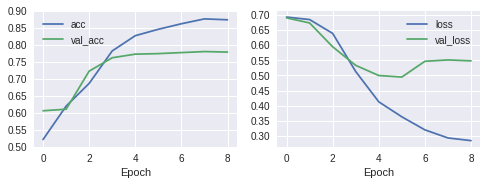

In [0]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=' ')
tokenizer.fit_on_texts(df['sentence'].values)

X = tokenizer.texts_to_sequences(df['sentence'].values)
X = pad_sequences(X, maxlen=max_token_per_phrase)

y = pd.get_dummies(df['score']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['score'].values, 
                                                    test_size=0.2, 
                                                    random_state=4422)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                  stratify=y_train, 
                                                  test_size=0.3, 
                                                  random_state=4422)

model2 = make_model(params_lstm_sentiment)
history2 = model2.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2,
                    callbacks=[early_stopping_val, plot_history],
                    validation_data=(X_val, y_val))

Difference of almost 3 points of accuracy between the prepared and unprepared dataset.